# 📘 XRPlace: Распознавание дверей, окон и назначения помещений на плане


## 📌 Цель проекта

Компания **XRPlace** разрабатывает интерактивные 3D-модели квартир и домов, которые можно осматривать в браузере от первого лица.  
Для автоматизации создания 3D-сцен необходимо автоматически определять **дверные и оконные проёмы**, а также, по возможности, **назначение помещений** по изображениям архитектурных планов.

---

## 🧠 Задачи проекта

- Исследование открытых датасетов планов помещений.
- Выбор предобученной модели и типа задачи:
  - Object Detection / Segmentation — для дверей и окон,
  - Classification — для типа помещения.
- Обучение модели на открытых данных.
- Постпроцессинг: преобразование масок/bbox в координаты.
- Тестирование на пользовательских данных.
- Разработка интерактивного Gradio-приложения.
- Анализ ошибок модели и улучшение.

---

## 🛠️ Используемый стек

- **YOLOv11** + **PyTorch** — детекция и сегментация.
- **Roboflow API** — загрузка датасетов.
- **OpenCV**, **Pillow**, **NumPy** — обработка изображений.
- **matplotlib**, **seaborn** — визуализация.
- **Gradio** — демо-интерфейс.
- Метрики: **IoU**, **mAP**.

---

## Содержание

**1. Получение и анализ данных**

**2. Выбор модели**

**3. Обучение**

**4. Постпроцессинг**

**5. Анализ ошибок**

**6. Gradio-приложение**

**7. Результаты**

---


In [52]:
!pip install albumentations opencv-python tqdm -q

In [53]:
!pip install ultralytics  -q

In [54]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from PIL import Image, ImageDraw
import yaml
from ultralytics import YOLO
import importlib 
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm



In [55]:
def eda_df(path):
    base_path = Path(path)
    # Директории
    train_img_dir = base_path / "train" / "images"
    train_lbl_dir = base_path / "train" / "labels"
    yaml_path = base_path / "data.yaml" 

    # список изображений и аннотаций
    image_files = (
        glob.glob(str(train_img_dir / "*.jpg")) + 
        glob.glob(str(train_img_dir / "*.JPG")) +
        glob.glob(str(train_img_dir / "*.png")) +
        glob.glob(str(train_img_dir / "*.PNG"))
    )

    label_files = glob.glob(str(train_lbl_dir / "*.txt"))

    print(f"Кол-во изображений: {len(image_files)}")
    print(f"Кол-во файлов аннотаций: {len(label_files)}")
    print("---")

    # Размеры изображений
    image_sizes = []
    for img_path in image_files:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)  # (width, height)

    df_sizes = pd.DataFrame(image_sizes, columns=["width", "height"])
    print(df_sizes.describe())

    # Распределение по классам
    class_counts = Counter()
    for lbl_file in label_files:
        with open(lbl_file, "r") as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_counts[class_id] += 1
    print("---\n\nРаспределение объектов по классам:\n")
    for class_id, count in sorted(class_counts.items()):
        print(f"Класс {class_id}: {count} объектов")

    # Загрузка классов из data.yaml
    with open(yaml_path, "r") as f:
        data_cfg = yaml.safe_load(f)

    class_names = data_cfg.get("names", {})  
    print("---")
    print("Классы:", class_names)

    return [train_img_dir, train_lbl_dir, class_names],   # возвращаем Path-объект

def show_image_labels(train_img_dir, train_lbl_dir, class_names, img_index):
    # ==== Выбор изображения ====
    img_path = sorted(list(train_img_dir.glob("*.jpg")) 
                      + list(train_img_dir.glob("*.png")))[img_index]
    img_name = img_path.stem
    label_path = train_lbl_dir / f"{img_name}.txt"

    # ==== Загрузка изображения ====
    image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    w_img, h_img = image.size

    # ==== Чтение и отрисовка аннотаций ====
    with open(label_path, "r") as f:
        for line in f.readlines():
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            
            # Преобразуем YOLO координаты в абсолютные
            x0 = (x_center - width / 2) * w_img
            y0 = (y_center - height / 2) * h_img
            x1 = (x_center + width / 2) * w_img
            y1 = (y_center + height / 2) * h_img

            class_name = class_names[int(class_id)] if int(class_id) in class_names else str(int(class_id))

            # Отрисовка прямоугольника и подписи
            draw.rectangle([x0, y0, x1, y1], outline="red", width=2)
            draw.text((x0, y0 - 10), class_name, fill="red")
        # ==== Отображение результата ====
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Аннотации для: {img_name}")
        plt.show()

def plot_box_distributions(labels_dir):
    """
    Строит гистограммы распределения ширины, высоты и площади боксов
    для каждого класса по YOLO-аннотациям из .txt файлов.

    :param labels_dir: Путь к папке с аннотациями в YOLO-формате.
    """
    box_stats = {}

    # Чтение всех файлов
    for filename in os.listdir(labels_dir):
        if filename.endswith(".txt"):
            with open(os.path.join(labels_dir, filename), 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    class_id, _, _, w, h = parts
                    class_id = int(class_id)
                    w = float(w)
                    h = float(h)
                    area = w * h

                    if class_id not in box_stats:
                        box_stats[class_id] = {'widths': [], 
                                               'heights': [], 
                                               'areas': [],
                                               'filename':[]}

                    box_stats[class_id]['widths'].append(w)
                    box_stats[class_id]['heights'].append(h)
                    box_stats[class_id]['areas'].append(area)
                    box_stats[class_id]['filename'].append(filename)

    if not box_stats:
        print("Нет данных для построения гистограмм.")
        return

    # Визуализация
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    bins = 50

    for class_id, stats in box_stats.items():
        axes[0].hist(stats['widths'], bins=bins, alpha=0.5, label=f'Класс {class_id}')
        axes[1].hist(stats['heights'], bins=bins, alpha=0.5, label=f'Класс {class_id}')
        axes[2].hist(stats['areas'], bins=bins, alpha=0.5, label=f'Класс {class_id}')

    # Подписи и оформление
    axes[0].set_title("Распределение ширины")
    axes[0].set_xlabel("Ширина")
    axes[0].set_ylabel("Количество")

    axes[1].set_title("Распределение высоты")
    axes[1].set_xlabel("Высота")

    axes[2].set_title("Распределение площади")
    axes[2].set_xlabel("Площадь")

    for ax in axes:
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


# Загрузка датасета

In [32]:
data_path ="../data/full_door_window"

In [46]:
train = eda_df(data_path)

Кол-во изображений: 547
Кол-во файлов аннотаций: 547
---
             width       height
count   547.000000   547.000000
mean    733.895795   672.570384
std     449.077930   339.505566
min     173.000000   278.000000
25%     416.000000   416.000000
50%     567.000000   542.000000
75%     860.000000   808.500000
max    2048.000000  2048.000000
---

Распределение объектов по классам:

Класс 0: 4519 объектов
Класс 1: 3442 объектов
---
Классы: ['door', 'window']


In [47]:
train_img_dir, train_lbl_dir, class_names = train[0]

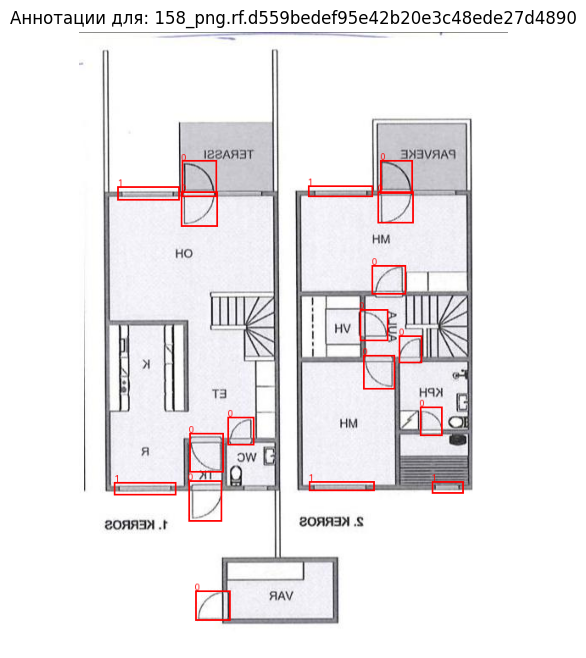

In [48]:
show_image_labels(train_img_dir, train_lbl_dir, class_names, 100)

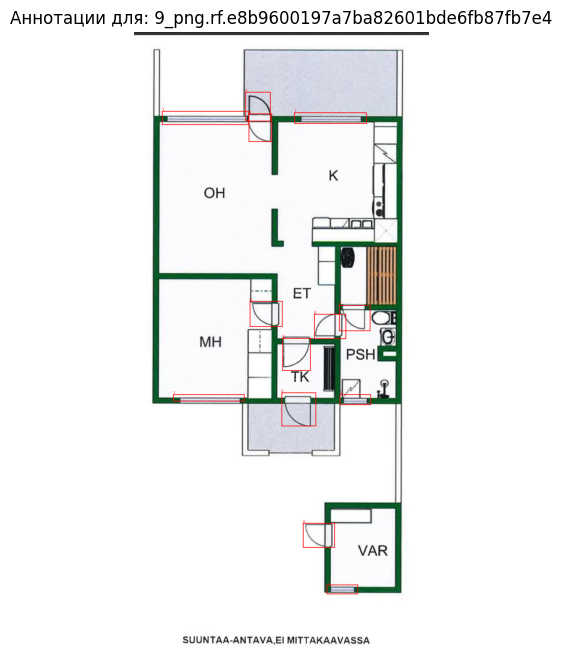

In [50]:
show_image_labels(train_img_dir, train_lbl_dir, class_names, 546)

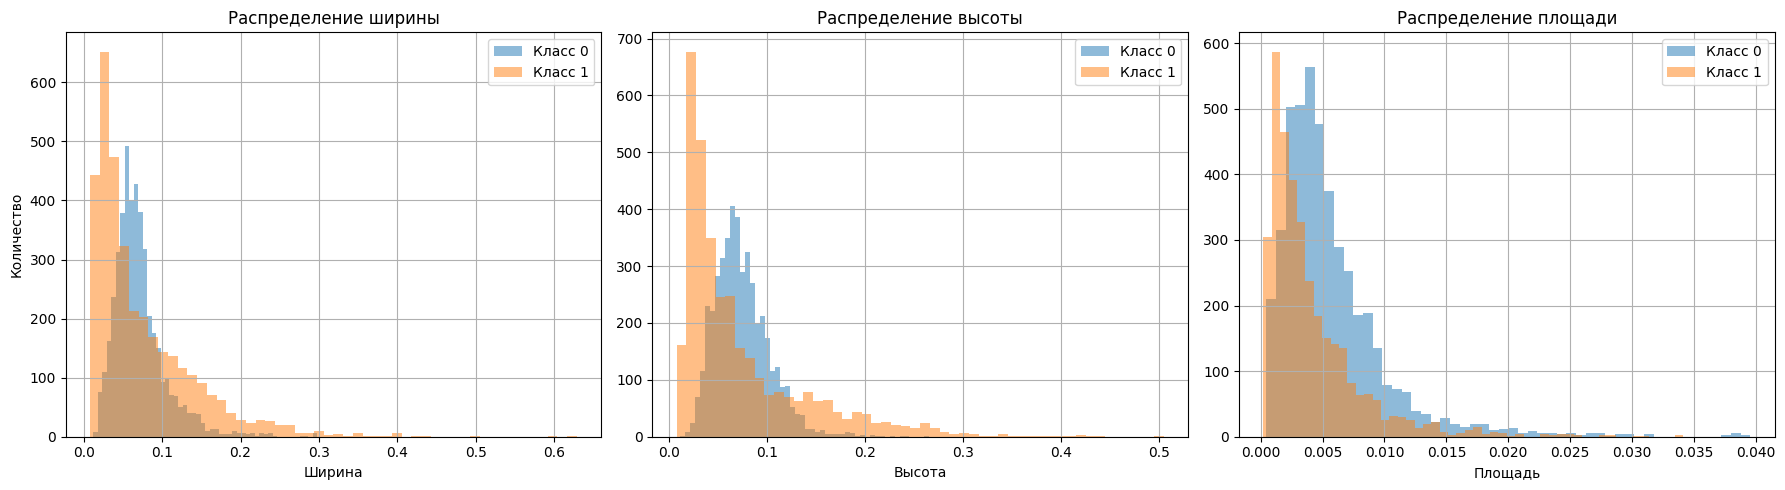

In [51]:
plot_box_distributions(train_lbl_dir)

# Аугментация

In [8]:
'''
# Пути
INPUT_IMAGES_DIR = '../data/ds_2/train/images'
INPUT_LABELS_DIR = '../data/ds_2/train/labels'
OUTPUT_IMAGES_DIR = '../data/ds_2/train/images'
OUTPUT_LABELS_DIR = '../data/ds_2/train/labels'

os.makedirs(OUTPUT_IMAGES_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABELS_DIR, exist_ok=True)

# Аугментации
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.Blur(p=0.2),
    A.Rotate(limit=15, p=0.5),
    A.RandomScale(scale_limit=0.1, p=0.5),
    A.CLAHE(p=0.2),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Процессинг
for image_file in tqdm(os.listdir(INPUT_IMAGES_DIR)):
    if not image_file.endswith(('.jpg', '.png', '.jpeg')):
        continue

    # Загрузка изображения
    image_path = os.path.join(INPUT_IMAGES_DIR, image_file)
    label_path = os.path.join(INPUT_LABELS_DIR, image_file.replace('.jpg', '.txt').replace('.png', '.txt'))

    image = cv2.imread(image_path)
    height, width, _ = image.shape

    # Загрузка аннотаций
    bboxes = []
    class_labels = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls, x, y, w, h = map(float, line.strip().split())
                bboxes.append([x, y, w, h])
                class_labels.append(int(cls))
    else:
        continue

    # Применение трансформации
    for i in range(3):  # 3 аугментированные копии
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['class_labels']

        # Сохранение
        aug_img_name = image_file.replace('.jpg', f'_aug{i}.jpg').replace('.png', f'_aug{i}.jpg')
        aug_label_name = aug_img_name.replace('.jpg', '.txt')

        cv2.imwrite(os.path.join(OUTPUT_IMAGES_DIR, aug_img_name), aug_image)

        with open(os.path.join(OUTPUT_LABELS_DIR, aug_label_name), 'w') as f:
            for cls, bbox in zip(aug_labels, aug_bboxes):
                f.write(f"{int(cls)} {' '.join(f'{v:.6f}' for v in bbox)}\n")
                
'''

100%|██████████| 591/591 [00:23<00:00, 25.67it/s]


# Обучение Yolo (детексиця дверей)

In [56]:
# Загружаем предобученную yolo11n.pt
model = YOLO("../models/yolo11n.pt") 

In [57]:
model_name = 'xrplace_yolo_door_window'

In [58]:
results = model.train(
    data="../data/full_door_window/data.yaml",  
    epochs=45,          # Максимальное число эпох (обучение может остановиться раньше)
    patience=10,        # Ранняя остановка, если нет улучшений 10 эпох подряд
    imgsz=640,
    batch=8,
    project="../models",  
    name=model_name,   
    verbose=True
)


Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/full_door_window/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=45, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=../models/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=xrplace_yolo_door_window, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0

train: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/full_door_window/train/labels... 547 images, 0 backgrounds, 0 corrupt: 100%|██████████| 547/547 [00:00<00:00, 1458.93it/s]


train: New cache created: /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/full_door_window/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 217.4±284.2 MB/s, size: 79.4 KB)


val: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/full_door_window/valid/labels... 78 images, 0 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<00:00, 1902.39it/s]

val: New cache created: /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/full_door_window/valid/labels.cache
Plotting labels to ../models/xrplace_yolo_door_window/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to ../models/xrplace_yolo_door_window
Starting training for 45 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/45         0G      1.675      2.687      1.188         53        640: 100%|██████████| 69/69 [02:59<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

                   all         78       1210      0.946      0.147      0.516       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/45         0G      1.498      1.293      1.092         22        640: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

                   all         78       1210      0.746      0.739      0.773      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/45         0G      1.457      1.159       1.08         52        640: 100%|██████████| 69/69 [02:50<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

                   all         78       1210      0.772      0.731      0.771      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/45         0G      1.389      1.073      1.055         45        640: 100%|██████████| 69/69 [02:50<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

                   all         78       1210      0.822      0.774       0.84      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/45         0G      1.362      1.019      1.044         72        640: 100%|██████████| 69/69 [02:49<00:00,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

                   all         78       1210       0.83      0.823       0.87      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/45         0G      1.353     0.9792      1.036         59        640: 100%|██████████| 69/69 [02:53<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

                   all         78       1210      0.807      0.797      0.851      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/45         0G      1.357     0.9508      1.038         55        640: 100%|██████████| 69/69 [02:58<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

                   all         78       1210      0.842      0.831      0.867      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/45         0G      1.356     0.9528      1.045         37        640: 100%|██████████| 69/69 [02:48<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

                   all         78       1210      0.846      0.797      0.856      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/45         0G      1.319     0.9039      1.025         63        640: 100%|██████████| 69/69 [02:52<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]

                   all         78       1210      0.873      0.833      0.894      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/45         0G      1.319       0.88      1.027         64        640: 100%|██████████| 69/69 [03:11<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

                   all         78       1210      0.848      0.833      0.885      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/45         0G      1.291     0.8621      1.025         41        640: 100%|██████████| 69/69 [03:07<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:20<00:00,  4.05s/it]

                   all         78       1210      0.862       0.82      0.894      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/45         0G      1.295     0.8434      1.002         71        640: 100%|██████████| 69/69 [03:36<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.82s/it]

                   all         78       1210      0.858      0.833      0.898       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/45         0G      1.278     0.8222      1.003         58        640: 100%|██████████| 69/69 [04:20<00:00,  3.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:25<00:00,  5.19s/it]

                   all         78       1210      0.885      0.845       0.91      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/45         0G      1.277     0.8141      1.011         33        640: 100%|██████████| 69/69 [05:14<00:00,  4.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.89s/it]

                   all         78       1210      0.853      0.861      0.911      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/45         0G      1.283     0.8106      1.004        121        640: 100%|██████████| 69/69 [04:55<00:00,  4.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:28<00:00,  5.71s/it]

                   all         78       1210       0.87      0.816      0.883      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/45         0G      1.316     0.8168      1.022         81        640: 100%|██████████| 69/69 [04:13<00:00,  3.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:20<00:00,  4.19s/it]

                   all         78       1210      0.857       0.83      0.899      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/45         0G      1.254      0.763     0.9886         72        640: 100%|██████████| 69/69 [05:29<00:00,  4.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.56s/it]

                   all         78       1210      0.881      0.865      0.916      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/45         0G      1.252     0.7608     0.9934        101        640: 100%|██████████| 69/69 [03:34<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:17<00:00,  3.56s/it]

                   all         78       1210      0.899      0.854      0.922      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/45         0G       1.27      0.773      1.005         33        640: 100%|██████████| 69/69 [03:56<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

                   all         78       1210      0.894      0.865      0.927      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/45         0G      1.236     0.7325      0.985         44        640: 100%|██████████| 69/69 [03:46<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

                   all         78       1210      0.872      0.862      0.917      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/45         0G      1.239     0.7323     0.9901        103        640: 100%|██████████| 69/69 [03:20<00:00,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<00:00,  4.21s/it]

                   all         78       1210      0.857      0.882      0.919      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/45         0G      1.243     0.7345     0.9939         82        640: 100%|██████████| 69/69 [03:47<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.64s/it]

                   all         78       1210      0.884      0.876      0.927      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/45         0G      1.226     0.7129     0.9909        121        640: 100%|██████████| 69/69 [04:27<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

                   all         78       1210      0.884      0.868      0.922      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/45         0G      1.218     0.7015     0.9782         53        640: 100%|██████████| 69/69 [04:52<00:00,  4.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

                   all         78       1210      0.898      0.859       0.93      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/45         0G      1.191     0.7019     0.9776         50        640: 100%|██████████| 69/69 [03:23<00:00,  2.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

                   all         78       1210      0.898      0.858       0.93      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/45         0G       1.22     0.6972     0.9823         85        640: 100%|██████████| 69/69 [04:05<00:00,  3.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.71s/it]

                   all         78       1210      0.887      0.884      0.931      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/45         0G      1.221     0.6949     0.9761        123        640: 100%|██████████| 69/69 [04:57<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:17<00:00,  3.51s/it]

                   all         78       1210      0.879      0.887      0.935      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/45         0G      1.221      0.688     0.9853         59        640: 100%|██████████| 69/69 [06:02<00:00,  5.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

                   all         78       1210      0.863      0.884      0.914      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/45         0G      1.205     0.6737     0.9794         38        640: 100%|██████████| 69/69 [05:31<00:00,  4.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.71s/it]

                   all         78       1210      0.885      0.867      0.925      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/45         0G      1.183     0.6704     0.9693         88        640: 100%|██████████| 69/69 [07:56<00:00,  6.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.40s/it]

                   all         78       1210      0.898      0.882      0.936      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/45         0G      1.185     0.6601     0.9672        100        640: 100%|██████████| 69/69 [06:37<00:00,  5.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

                   all         78       1210      0.879      0.895       0.94      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/45         0G      1.179     0.6522     0.9698         37        640: 100%|██████████| 69/69 [03:49<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

                   all         78       1210      0.865      0.913       0.94      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/45         0G      1.191     0.6613     0.9771         38        640: 100%|██████████| 69/69 [04:04<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]

                   all         78       1210      0.877      0.881      0.928      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/45         0G      1.176     0.6483     0.9638        133        640: 100%|██████████| 69/69 [04:23<00:00,  3.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

                   all         78       1210      0.912      0.882      0.939      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/45         0G      1.183     0.6621     0.9685         29        640: 100%|██████████| 69/69 [05:36<00:00,  4.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:30<00:00,  6.12s/it]

                   all         78       1210      0.896      0.893      0.935      0.603


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/45         0G      1.153     0.6345     0.9798         15        640: 100%|██████████| 69/69 [04:02<00:00,  3.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:20<00:00,  4.03s/it]

                   all         78       1210      0.887      0.891      0.936      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/45         0G      1.142     0.6288     0.9756         23        640: 100%|██████████| 69/69 [04:21<00:00,  3.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

                   all         78       1210      0.878      0.884      0.931       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/45         0G       1.13     0.6121     0.9741         28        640: 100%|██████████| 69/69 [03:14<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:17<00:00,  3.49s/it]

                   all         78       1210      0.904      0.864      0.933      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/45         0G      1.131     0.6116     0.9698         57        640: 100%|██████████| 69/69 [03:50<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.70s/it]

                   all         78       1210      0.903      0.882      0.938      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/45         0G      1.114      0.592     0.9706         26        640: 100%|██████████| 69/69 [03:58<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:18<00:00,  3.73s/it]

                   all         78       1210      0.913       0.88      0.942      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/45         0G      1.114      0.595     0.9656         35        640: 100%|██████████| 69/69 [03:47<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:18<00:00,  3.65s/it]

                   all         78       1210      0.884      0.902      0.942      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/45         0G      1.101     0.5841     0.9548         70        640: 100%|██████████| 69/69 [04:17<00:00,  3.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.97s/it]

                   all         78       1210      0.898      0.893      0.947      0.608
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 32, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



42 epochs completed in 3.096 hours.
Optimizer stripped from ../models/xrplace_yolo_door_window/weights/last.pt, 5.5MB
Optimizer stripped from ../models/xrplace_yolo_door_window/weights/best.pt, 5.5MB

Validating ../models/xrplace_yolo_door_window/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


                   all         78       1210      0.865      0.913       0.94      0.613
                  door         78        696        0.9      0.953      0.974      0.693
                window         78        514       0.83      0.874      0.906      0.533
Speed: 2.6ms preprocess, 235.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to ../models/xrplace_yolo_door_window


In [8]:
metrics = model.val()

Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 465.3±578.8 MB/s, size: 26.4 KB)


val: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/ds_2/valid/labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


                   all         56        990      0.913      0.847      0.913      0.574
                  door         56        527      0.955      0.937      0.962      0.681
                window         56        463      0.871      0.756      0.864      0.468
Speed: 1.0ms preprocess, 58.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to ../models/xrplace_model_first52


In [18]:
model = YOLO("../models/xrplace_model_first/weights/best.pt")

metrics = model.val(
    data="../data/door_yolo11/data.yaml",
    imgsz=640,
    split='val',
    project="../models/" + model_name,     # Папка, куда сохранить
    name="validation1"        # Название подпапки внутри project
)

print(metrics)


Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 95.8±30.4 MB/s, size: 27.7 KB)


val: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/door_yolo11/valid/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


                   all         10         31      0.998          1      0.995      0.844
Speed: 3.7ms preprocess, 124.0ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to ../models/xrplace_model_first/validation1
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x1211515d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,

In [21]:
# Загружаем лучшую модель после обучения
model = YOLO("../models/xrplace_model_first/weights/best.pt")

# Выбираем тестовое изображение
test_image = "../data/door_yolo11/test/images"

results = model.predict(
    source=test_image, 
    imgsz=640,
    save=True,                        # сохранить предсказания
    save_txt=True,          # сохранить координаты bbox в .txt
    project="../models/"+model_name+'/test',
    name="inference_run1",          
    exist_ok=True                    # перезаписать если уже есть
)


image 1/8 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/door_yolo11/test/images/Cat11_7_jpg.rf.96d24b654a88cc171f9e66c841c57383.jpg: 640x640 3 doors, 120.7ms
image 2/8 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/door_yolo11/test/images/Cat12_2_jpg.rf.00871227806f66c22856b26a337a5565.jpg: 640x640 3 doors, 71.1ms
image 3/8 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/door_yolo11/test/images/Cat13_1_jpg.rf.925104a19cb4ae97b8f7d06f39b731a4.jpg: 640x640 3 doors, 93.6ms
image 4/8 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/door_yolo11/test/images/Cat14_2_jpg.rf.a5c1b33142383282097d4068c9d89ec4.jpg: 640x640 3 doors, 68.4ms
image 5/8 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/door_yolo11/test/images/Cat2_4_jpg.rf.a1d31561ffa9a2a8271501740fe0f198.jpg: 640x640 3 doors, 62.2ms
image 6/8 /Users/irinami

# Дообучение (двери и окна)

In [22]:
# Загружаем предобученную 
model_step2 = YOLO("../models/xrplace_model_first/weights/best.pt") 

In [23]:
model_name_step2 = 'xrplace_model_step2'

In [24]:
results_step2 = model.train(
    data="../data/door_window/data.yaml",  
    epochs=45,          # Максимальное число эпох (обучение может остановиться раньше)
    patience=10,        # Ранняя остановка, если нет улучшений 10 эпох подряд
    imgsz=640,
    batch=8,
    project="../models",  
    name=model_name,   
    verbose=True
)

Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/door_window/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=45, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=../models/xrplace_model_first/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=xrplace_model_first2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots

train: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/door_window/train/labels... 590 images, 7 backgrounds, 0 corrupt: 100%|██████████| 590/590 [00:00<00:00, 1413.95it/s]

train: New cache created: /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/door_window/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 234.1±124.6 MB/s, size: 78.8 KB)


val: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/door_window/valid/labels... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<00:00, 1666.32it/s]

val: New cache created: /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/door_window/valid/labels.cache


Plotting labels to ../models/xrplace_model_first2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to ../models/xrplace_model_first2
Starting training for 45 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/45         0G      2.535      2.754      1.786        161        640: 100%|██████████| 74/74 [03:46<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.79s/it]

                   all         56        990      0.538      0.312      0.344      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/45         0G      1.856      1.713      1.297        104        640: 100%|██████████| 74/74 [03:59<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.90s/it]

                   all         56        990       0.73      0.619      0.682      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/45         0G      1.701      1.382      1.206        147        640: 100%|██████████| 74/74 [03:24<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.84s/it]

                   all         56        990      0.754      0.661      0.739      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/45         0G      1.612      1.234      1.159        121        640: 100%|██████████| 74/74 [03:12<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.71s/it]

                   all         56        990      0.829       0.71      0.788      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/45         0G      1.548      1.132      1.111        122        640: 100%|██████████| 74/74 [03:17<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]

                   all         56        990      0.849      0.747      0.824      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/45         0G       1.51      1.091        1.1        238        640: 100%|██████████| 74/74 [03:32<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]

                   all         56        990      0.894      0.734      0.826      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/45         0G      1.478      1.042      1.077        128        640: 100%|██████████| 74/74 [03:46<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.94s/it]

                   all         56        990      0.862      0.783      0.854      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/45         0G      1.435     0.9837      1.061        112        640: 100%|██████████| 74/74 [03:33<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

                   all         56        990      0.869      0.798      0.856      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/45         0G      1.441     0.9851      1.065        200        640: 100%|██████████| 74/74 [03:54<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.94s/it]

                   all         56        990      0.886      0.768      0.852       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/45         0G      1.413     0.9476      1.044        167        640: 100%|██████████| 74/74 [03:45<00:00,  3.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.85s/it]

                   all         56        990      0.851      0.789      0.849      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/45         0G      1.369     0.9177      1.038        140        640: 100%|██████████| 74/74 [03:23<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.50s/it]

                   all         56        990       0.89      0.814      0.871      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/45         0G      1.357     0.8951      1.026        157        640: 100%|██████████| 74/74 [03:11<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]

                   all         56        990      0.862      0.833      0.869      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/45         0G      1.354      0.881      1.021        148        640: 100%|██████████| 74/74 [03:16<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]

                   all         56        990      0.899       0.79      0.866      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/45         0G      1.327      0.852      1.008        129        640: 100%|██████████| 74/74 [03:20<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.75s/it]

                   all         56        990      0.888      0.821      0.879       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/45         0G      1.323     0.8364      1.009        153        640: 100%|██████████| 74/74 [03:30<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.09s/it]

                   all         56        990       0.89      0.848      0.888      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/45         0G      1.306     0.8225      1.002        121        640: 100%|██████████| 74/74 [03:25<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.92s/it]

                   all         56        990      0.895       0.82      0.884      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/45         0G      1.286     0.8006     0.9972        141        640: 100%|██████████| 74/74 [03:39<00:00,  2.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.22s/it]

                   all         56        990      0.906      0.819      0.884      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/45         0G      1.289     0.8034     0.9921        169        640: 100%|██████████| 74/74 [03:53<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.87s/it]

                   all         56        990      0.917      0.829      0.893      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/45         0G      1.276     0.7875     0.9945         94        640: 100%|██████████| 74/74 [03:24<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.84s/it]

                   all         56        990      0.891      0.848      0.895      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/45         0G      1.297     0.7952     0.9931         92        640: 100%|██████████| 74/74 [03:50<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

                   all         56        990      0.915       0.84      0.896      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/45         0G      1.252     0.7808     0.9874         98        640: 100%|██████████| 74/74 [03:58<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.93s/it]

                   all         56        990      0.912      0.843      0.903      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/45         0G      1.269     0.7651     0.9761        132        640: 100%|██████████| 74/74 [04:13<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.92s/it]

                   all         56        990      0.869      0.836      0.877      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/45         0G      1.242     0.7506     0.9793        210        640: 100%|██████████| 74/74 [03:41<00:00,  2.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.14s/it]

                   all         56        990      0.919      0.849      0.907      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/45         0G      1.254     0.7579     0.9776        145        640: 100%|██████████| 74/74 [04:00<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]

                   all         56        990      0.902       0.84      0.898      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/45         0G      1.233     0.7428     0.9783        147        640: 100%|██████████| 74/74 [03:34<00:00,  2.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]

                   all         56        990       0.91      0.843      0.902      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/45         0G       1.23     0.7333      0.974         89        640: 100%|██████████| 74/74 [03:42<00:00,  3.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.43s/it]

                   all         56        990      0.916      0.833        0.9      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/45         0G      1.253     0.7368     0.9777        171        640: 100%|██████████| 74/74 [03:19<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]

                   all         56        990      0.904      0.854        0.9       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/45         0G      1.227     0.7238     0.9779        122        640: 100%|██████████| 74/74 [20:06<00:00, 16.30s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.65s/it]

                   all         56        990      0.914      0.834      0.896      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/45         0G      1.253     0.7363      0.977        112        640: 100%|██████████| 74/74 [13:56<00:00, 11.30s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]

                   all         56        990      0.906      0.851      0.904      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/45         0G       1.25     0.7205     0.9772        118        640: 100%|██████████| 74/74 [03:02<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]

                   all         56        990        0.9      0.867      0.907       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/45         0G      1.216     0.7022     0.9615        163        640: 100%|██████████| 74/74 [18:11<00:00, 14.75s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.48s/it]

                   all         56        990      0.906       0.84      0.899       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/45         0G      1.228     0.7096     0.9719        186        640: 100%|██████████| 74/74 [06:18<00:00,  5.11s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.22s/it]

                   all         56        990      0.919      0.841      0.899      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/45         0G        1.2     0.6994      0.967        150        640: 100%|██████████| 74/74 [03:05<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]

                   all         56        990      0.908      0.858      0.909      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/45         0G      1.193     0.6957     0.9542        223        640: 100%|██████████| 74/74 [03:04<00:00,  2.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]

                   all         56        990      0.915      0.862      0.915      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/45         0G      1.188     0.6945     0.9597        147        640: 100%|██████████| 74/74 [08:25<00:00,  6.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.25s/it]

                   all         56        990      0.892      0.874      0.912      0.586


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/45         0G      1.164     0.6855     0.9677         70        640: 100%|██████████| 74/74 [03:30<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.24s/it]

                   all         56        990      0.904      0.857      0.911      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      37/45         0G      1.158     0.6643     0.9651         79        640: 100%|██████████| 74/74 [06:47<00:00,  5.50s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.33s/it]

                   all         56        990      0.917      0.841      0.904      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/45         0G      1.149      0.651     0.9636         70        640: 100%|██████████| 74/74 [04:08<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.05s/it]

                   all         56        990      0.904      0.855       0.91      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/45         0G       1.14     0.6517     0.9546         63        640: 100%|██████████| 74/74 [03:52<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.92s/it]

                   all         56        990      0.891      0.873      0.918      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/45         0G      1.132     0.6403     0.9497        122        640: 100%|██████████| 74/74 [03:33<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]

                   all         56        990        0.9      0.859      0.914       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/45         0G      1.126      0.635     0.9519        168        640: 100%|██████████| 74/74 [03:20<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.17s/it]

                   all         56        990      0.916      0.855      0.912       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/45         0G      1.119     0.6283     0.9552         77        640: 100%|██████████| 74/74 [03:13<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]

                   all         56        990      0.905      0.867      0.918      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/45         0G      1.112     0.6223     0.9528         92        640: 100%|██████████| 74/74 [03:16<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]

                   all         56        990      0.908      0.859      0.919      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/45         0G      1.121     0.6292     0.9496         73        640: 100%|██████████| 74/74 [03:19<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]

                   all         56        990       0.91       0.85      0.914      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/45         0G      1.115     0.6248     0.9454         87        640: 100%|██████████| 74/74 [04:45<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.33s/it]

                   all         56        990      0.908      0.856      0.914      0.583



45 epochs completed in 3.700 hours.
Optimizer stripped from ../models/xrplace_model_first2/weights/last.pt, 5.5MB
Optimizer stripped from ../models/xrplace_model_first2/weights/best.pt, 5.5MB

Validating ../models/xrplace_model_first2/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.93s/it]


                   all         56        990      0.911      0.849      0.914      0.587
                  door         56        527      0.967      0.937      0.968      0.684
                window         56        463      0.855      0.762      0.861       0.49
Speed: 2.7ms preprocess, 241.2ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to ../models/xrplace_model_first2


In [ ]:
# ✅ Этап 6 (опционально): Классификация назначения помещения
# Здесь может быть реализована отдельная модель


In [ ]:
# ✅ Этап 7: Тестирование на данных заказчика
test_image_path = "PATH/TO/CLIENT_IMAGE.png"
results = model(test_image_path)
results[0].save(filename="prediction.jpg")


In [ ]:
# ✅ Этап 8: Gradio приложение
import gradio as gr

def detect_doors_windows(image):
    results = model(image)
    annotated = results[0].plot()
    return Image.fromarray(annotated)

demo = gr.Interface(
    fn=detect_doors_windows,
    inputs=gr.Image(type="filepath"),
    outputs=gr.Image(type="pil"),
    title="XRPlace: Распознавание окон и дверей",
    description="Модель определяет окна и двери на плане помещения",
)
demo.launch()


In [ ]:
# ✅ Этап 9: Метрики оценки
metrics = model.val()
print(metrics)


In [ ]:
# ✅ Этап 10: Анализ ошибок
# Пример визуализации false positives / false negatives

def analyze_errors(results, conf_thresh=0.5):
    for r in results:
        boxes = r.boxes.xyxy.cpu().numpy()
        confs = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy()
        for box, conf, cls in zip(boxes, confs, classes):
            if conf < conf_thresh:
                print(f"False positive (низкая уверенность): Класс {cls}, conf={conf:.2f}, box={box}")
        # Дополнительно: сравнение с ground truth для выявления пропущенных объектов

analyze_errors(results)


## ✅ Финальный вывод
- Модель определяет координаты дверей и окон
- Потенциально классифицирует тип помещения
- Есть Gradio-демо
- Метрики (IoU/mAP) позволяют объективно сравнивать модели
- Анализ ошибок помогает улучшать предсказания
